In [1]:
import tetrion.commands as cmd
import tetrion.db
import tetrion.options
import tetrion.clientcore
import datetime as dt
import tetrion.config
import statsmodels.api as sm
import pandas as pd
import zmq
import ujson
import pickle
import glob
import seaborn as sns
import numpy as np
import sys
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
symbol = pd.read_csv('/local/dist/tetrion/conf/conf/symbol.table', skiprows= 1, header = 2,  delim_whitespace=True)
from joblib import Parallel, delayed
import collections
import multiprocessing
import itertools
import redis
import json
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

/tmp/ipykernel_43785/4016521052.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


/tmp/ipykernel_43785/4016521052.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  symbol = pd.read_csv('/local/dist/tetrion/conf/conf/symbol.table', skiprows= 1, header = 2,  delim_whitespace=True)


In [2]:
import redis
import json
def get_fills_from_redis(strat = 'capital_txo_main', acc='TAIFEX100',date=dt.date.today(),night_session=False, redishost='prod1.capital.radiant-knight.com'):
    r = redis.StrictRedis(host=redishost, port=6379,db=0)
    rk = '{}:{}'.format(acc, date.strftime('%Y%m%d'))
    rk_strat = '{}:{}'.format(strat, date.strftime('%Y%m%d'))
    if night_session:
        rk = rk + 'E'
        rk_strat = rk_strat + 'E'
    if rk not in [k.decode() for k in r.keys()]:
        print('Key:{} not exists!'.format(rk))
        if rk_strat in [k.decode() for k in r.keys()]:
            rk = rk_strat
        else:
            return None
    msgs = r.lrange(rk, 0, -1)
    trd_df = pd.DataFrame([json.loads(m.decode()) for m in msgs])
    if trd_df.empty:
        print('Empty redis key')
        return None
    if trd_df['ts'][0] > 1e11:
        trd_df['time'] = trd_df['ts'].apply(lambda x:dt.datetime.fromtimestamp(x/1e6))
    else:
        trd_df['time'] = trd_df['ts'].apply(lambda x:dt.datetime.fromtimestamp(x))
    trd_df.set_index('time',inplace=True)

    return trd_df

#### 算損益

Loading fills by day: 100%|██████████| 1/1 [00:00<00:00, 36.76it/s]


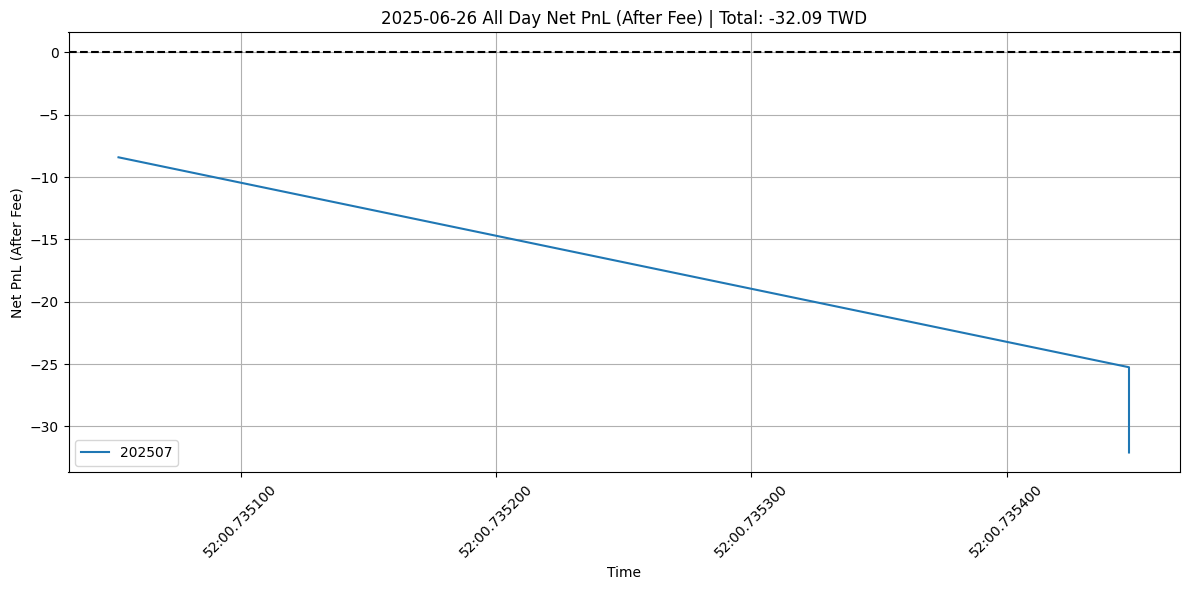


 2025-06-26 Top Ten Loss：
                      Time Contract Product  Price  size  Cumulative Position  PnL Change      Fee   PnL Net
2025-06-26 12:52:00.735448   202507     TMF 2093.6    -2                  -10         0.0 16.83744 -16.83744
2025-06-26 12:52:00.735052   202507     TMF 2093.6     1                   10         0.0  8.41872  -8.41872
2025-06-26 12:52:00.735448   202507     TMF 2092.6    -2                  -30        10.0 16.83704  -6.83704

 2025-06-26 各到期月份總損益：
  202507: -32.09 TWD

 2025-06-26 當日總損益： -32.09 TWD


In [3]:
from electron_backtest.Backtestingtools.electron_pnl_analyzer import PnLAnalyzer
from electron_backtest.Backtestingtools import trade_loader

date = '2025-06-26'
df_dict = trade_loader.build_df_dict2('2025,6,26', '2025,6,26', strat='capital_neutrino_fxf_5f')
d = pd.to_datetime(date).date()
df = df_dict[d]
df = df[df['time']> pd.to_datetime(date)+dt.timedelta(hours=8, minutes=45)]
df = {d:df}

# PnLAnalyzer
analyzer = PnLAnalyzer(df)
# carry + pnl
analyzer.run_full_report()

In [4]:
# 成交資料
def compute_fee(product, px, sz, mult):
    tax_rate = 0.00002
    if 'TXF' in product:
        fix_fee = 12 + 8
    elif 'MXF' in product: 
        fix_fee = 7.5 + 5
    elif 'TMF' in product:
        fix_fee = 4.8 + 3.2
    elif 'FXF' in product:
        fix_fee = 12 + 8
    elif 'ZFF' in product:
        fix_fee = 4.8 + 3.2
    else:
        print('Unknown product:', product)
        fix_fee = 0
    tax_fee = abs(px * sz * mult) * tax_rate
    fee = abs(sz * fix_fee )+ tax_fee
    return fee

def daily_pnl_neutrino(strategy, d, night=False):

    trade_fill=get_fills_from_redis(strategy, date=d, night_session=night).reset_index()
    floor = '5f' if strategy[-2:]=='5f' else '6f'
    pnl_df = pd.DataFrame(columns=['floor','expiry','pnl(twd)'])
    pnl_fill = pd.DataFrame(columns=['time', 'floor', 'expiry', 'pnl(twd)', 'type'])
   
    if trade_fill is None:
        pnl_df.loc[len(pnl_df)] = [floor, 'NaN', 0]
    else:
        trade_fill['expiry'] = trade_fill['instr'].apply(lambda x: x[-6:])
        trade_fill['contract'] = trade_fill['instr'].apply(lambda x: x[-10:-7])
        
        for expiry, group in trade_fill.groupby('expiry'):
            group = group.sort_values(by='ts')
            pos = 0
            value = 0
            alqortake = ''
            ct = ''
            time = None

            for _, row in group.iterrows():
                contract = row['contract']
                px = row['px']
                sz = row['sz']
                mult = row['mult']
                pos = pos + sz* mult
                value = value + (-1 * (px * mult * sz))
                fee = compute_fee(contract, px, sz, mult)
                value = value - fee

                if pos != 0:
                    if alqortake == '':
                        alqortake = row['alqortake']
                        ct = contract
                    else:
                        if alqortake == row['alqortake']:
                            alqortake = row['alqortake']
                    if time is None:
                        time = row['time']       
                else:
                    if (alqortake == 'take') & (alqortake == row['alqortake']) & (ct != row['contract']):
                        tp = 'fire'
                    else:
                        tp = 'quoting'
                    pnl_fill.loc[len(pnl_fill)] = [time, floor, expiry, value, tp]
                    pnl_df.loc[len(pnl_df)] = [floor, expiry, value]
                    value = 0
                    alqortake = ''
                    time = None    

    return pnl_df, pnl_fill

###
date = dt.date(2025,6,17)
strategy = ['capital_neutrino_txf_5f', 'capital_neutrino_txf']
result1, result2 = pd.DataFrame(), pd.DataFrame()

for s in strategy:
    pnl_df, pnl_fill = daily_pnl_neutrino(s, date)
    result1 = pd.concat([result1, pnl_df], axis=0)
    result2 = pd.concat([result2, pnl_fill], axis=0)

result1 = result1.groupby(['floor','expiry']).sum().reset_index().pivot(index='expiry', columns='floor', values='pnl(twd)').fillna(0)
result1 = result1.loc[~(result1.sum(axis=1)==0)]
result1.loc['sum'] = result1.sum(axis=0)
print(result1)

Key:TAIFEX100:20250617 not exists!
Key:TAIFEX100:20250617 not exists!
floor         5f        6f
expiry                    
202506   325.569   475.564
202507  1006.289   806.285
sum     1331.858  1281.849


In [5]:
f5 = result2[result2['floor']== '5f']
f6 = result2[result2['floor']== '6f']
print(f5.sort_values(by='pnl(twd)', ascending=False))
print(f6.sort_values(by='pnl(twd)', ascending=False))

                        time floor  expiry  pnl(twd)     type
2 2025-06-17 12:49:42.228648    5f  202507  1006.289  quoting
1 2025-06-17 08:45:00.154614    5f  202506  1002.761  quoting
0 2025-06-17 08:45:00.126416    5f  202506  -677.192  quoting
                        time floor  expiry  pnl(twd)     type
1 2025-06-17 08:45:00.154613    6f  202506   952.760  quoting
2 2025-06-17 12:49:42.228700    6f  202507   806.285  quoting
0 2025-06-17 08:45:00.126604    6f  202506  -477.196  quoting


In [6]:
date_range = pd.date_range(start='2025-06-01', end='2025-06-30')
strategy = ['capital_neutrino_txf','capital_neutrino_txf_5f']

fire_pnl = pd.DataFrame(columns=['date', 'floor', 'pnl(twd)'])
contract_pnl = pd.DataFrame(columns=['time','floor','expiry','pnl(twd)','type']) # 分類不同樓層/月份損益
alqorfire_count = pd.DataFrame() # 統計不同樓層/月份的quote/fire次數
full_day_6f = pd.DataFrame() # 6樓全日盤fire損益
for d in date_range:
    result1, result2 = pd.DataFrame(), pd.DataFrame()
    try:
        for s in strategy:
            if s[-5:] == 'night':
                s = s[:-6]
                night = True
            else:
                night = False
            pnl_df, pnl_fill = daily_pnl_neutrino(s, d.date(), night=night)
            result1 = pd.concat([result1, pnl_df], axis=0)
            result2 = pd.concat([result2, pnl_fill], axis=0)
        f5 = result2[(result2['floor']== '5f')&(result2['type']=='fire')]
        f6 = result2[(result2['floor']== '6f')&(result2['type']=='fire')]
        
        contract_pnl = pd.concat([contract_pnl, f5, f6], axis=0) 
        alqorfire_count = pd.concat([alqorfire_count, result2], axis=0) 
        
        f5_pnl = 0 if f5.empty else f5['pnl(twd)'].sum()
        f6_pnl = 0 if f6.empty else f6['pnl(twd)'].sum()
        fire_pnl.loc[len(fire_pnl)] = [d, '5f', f5_pnl]
        fire_pnl.loc[len(fire_pnl)] = [d, '6f', f6_pnl]
        f6['date'] = d.date()
        full_day_6f = pd.concat([full_day_6f, f6], axis=0) 
    except Exception as e:
        print(f"Error processing {d.date()}: {e}")
        continue


Key:TAIFEX100:20250601 not exists!
Error processing 2025-06-01: 'NoneType' object has no attribute 'reset_index'
Key:TAIFEX100:20250602 not exists!
Key:TAIFEX100:20250602 not exists!
Error processing 2025-06-02: 'NoneType' object has no attribute 'reset_index'
Key:TAIFEX100:20250603 not exists!
Key:TAIFEX100:20250603 not exists!
Key:TAIFEX100:20250604 not exists!
Key:TAIFEX100:20250604 not exists!


/tmp/ipykernel_43785/2640599776.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  contract_pnl = pd.concat([contract_pnl, f5, f6], axis=0)
/tmp/ipykernel_43785/2640599776.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f6['date'] = d.date()
/tmp/ipykernel_43785/2640599776.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

Key:TAIFEX100:20250605 not exists!
Key:TAIFEX100:20250605 not exists!
Key:TAIFEX100:20250606 not exists!
Key:TAIFEX100:20250606 not exists!
Key:TAIFEX100:20250607 not exists!
Error processing 2025-06-07: 'NoneType' object has no attribute 'reset_index'
Key:TAIFEX100:20250608 not exists!
Error processing 2025-06-08: 'NoneType' object has no attribute 'reset_index'
Key:TAIFEX100:20250609 not exists!
Key:TAIFEX100:20250609 not exists!
Key:TAIFEX100:20250610 not exists!
Key:TAIFEX100:20250610 not exists!
Key:TAIFEX100:20250611 not exists!
Error processing 2025-06-11: 'NoneType' object has no attribute 'reset_index'
Key:TAIFEX100:20250612 not exists!
Key:TAIFEX100:20250612 not exists!
Key:TAIFEX100:20250613 not exists!
Key:TAIFEX100:20250613 not exists!


/tmp/ipykernel_43785/2640599776.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f6['date'] = d.date()
/tmp/ipykernel_43785/2640599776.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f6['date'] = d.date()


Key:TAIFEX100:20250614 not exists!
Error processing 2025-06-14: 'NoneType' object has no attribute 'reset_index'
Key:TAIFEX100:20250615 not exists!
Error processing 2025-06-15: 'NoneType' object has no attribute 'reset_index'
Key:TAIFEX100:20250616 not exists!
Key:TAIFEX100:20250616 not exists!
Key:TAIFEX100:20250617 not exists!
Key:TAIFEX100:20250617 not exists!
Key:TAIFEX100:20250618 not exists!


/tmp/ipykernel_43785/2640599776.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f6['date'] = d.date()
/tmp/ipykernel_43785/2640599776.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f6['date'] = d.date()


Key:TAIFEX100:20250618 not exists!
Key:TAIFEX100:20250619 not exists!
Key:TAIFEX100:20250619 not exists!
Key:TAIFEX100:20250620 not exists!
Key:TAIFEX100:20250620 not exists!
Key:TAIFEX100:20250621 not exists!
Error processing 2025-06-21: 'NoneType' object has no attribute 'reset_index'
Key:TAIFEX100:20250622 not exists!
Error processing 2025-06-22: 'NoneType' object has no attribute 'reset_index'
Key:TAIFEX100:20250623 not exists!


/tmp/ipykernel_43785/2640599776.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f6['date'] = d.date()


Key:TAIFEX100:20250623 not exists!
Key:TAIFEX100:20250624 not exists!
Key:TAIFEX100:20250624 not exists!
Key:TAIFEX100:20250625 not exists!
Key:TAIFEX100:20250625 not exists!
Key:TAIFEX100:20250626 not exists!
Key:TAIFEX100:20250626 not exists!


/tmp/ipykernel_43785/2640599776.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f6['date'] = d.date()
/tmp/ipykernel_43785/2640599776.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f6['date'] = d.date()


Key:TAIFEX100:20250627 not exists!
Key:TAIFEX100:20250627 not exists!
Key:TAIFEX100:20250628 not exists!
Error processing 2025-06-28: 'NoneType' object has no attribute 'reset_index'
Key:TAIFEX100:20250629 not exists!
Error processing 2025-06-29: 'NoneType' object has no attribute 'reset_index'
Key:TAIFEX100:20250630 not exists!
Key:TAIFEX100:20250630 not exists!


In [26]:
contract_pnl

,time,floor,expiry,pnl(twd),type
0,2025-06-04 08:45:00.119847,5f,202506,-640.232,fire
0,2025-06-04 08:45:00.111580,6f,202506,-140.222,fire
1,2025-06-04 08:45:00.119794,6f,202506,-590.231,fire
0,2025-06-06 08:45:00.067906,5f,202506,1407.273,fire
1,2025-06-06 08:45:00.075009,5f,202506,-42.756,fire
2,2025-06-06 08:45:00.080556,5f,202506,-492.765,fire
0,2025-06-06 08:45:00.067861,6f,202506,1807.281,fire
1,2025-06-06 08:45:00.076046,6f,202506,-342.762,fire
0,2025-06-10 08:45:00.023885,5f,202506,-1244.964,fire
0,2025-06-10 08:45:00.023091,6f,202506,-1244.940,fire


In [25]:
df = alqorfire_count.copy()
df['date'] = pd.to_datetime(df['time']).dt.date
df = (
    df
    .groupby(['date', 'floor', 'type'])
    .agg(
        pnl_twd=('pnl(twd)', 'sum'),
        count=('pnl(twd)', 'count')
    )
    .round(0)
    .astype(int)
    .unstack(level=['floor','type'])  
)
#df = df.swaplevel(axis=1)
df.loc['sum'] = df.sum(axis=0)
df.fillna(0, inplace=True)
df['count'] = df['count'].astype(int)
df

pnl_twd                            count                  
floor           5f       6f      5f      6f      5f      6f   5f   6f
type       quoting  quoting    fire    fire quoting quoting fire fire
date                                                                 
2025-06-03 -1449.0  -1235.0     0.0     0.0      12       5    0    0
2025-06-04 -7057.0   -827.0  -640.0  -730.0      14       5    1    2
2025-06-05 -1195.0  -3751.0     0.0     0.0       8       5    0    0
2025-06-06 -1306.0   -306.0   872.0  1465.0       5       5    3    2
2025-06-09   561.0  -1711.0     0.0     0.0       8       5    0    0
2025-06-10  1269.0   4381.0 -1245.0 -1245.0       5       8    1    1
2025-06-12   202.0     52.0     0.0     0.0       1       1    0    0
2025-06-13   889.0   -751.0 -3184.0 -7221.0       7       6    2    4
2025-06-16  4708.0   5512.0 -1985.0  1369.0      11      12    2    3
2025-06-17  1332.0   1282.0     0.0     0.0       3       3    0    0
2025-06-18  3325.0   2682.0 -3683.0  -483.0       6       8    3    3
2025-06-19   535.0   1312.0     0.0     0.0       5       2    0    0
2025-06-20 -1702.0    -80.0  -886.0  -636.0       6       9    2    2
2025-06-23  3286.0   2929.0     0.0     0.0      18      27    0    0
2025-06-24  2571.0   2254.0     0.0     0.0       4       5    0    0
2025-06-25 -1446.0    154.0  -347.0  -997.0       1       1    1    1
2025-06-26  2962.0   2309.0     0.0     0.0       4       3    0    0
2025-06-27   210.0    607.0  2435.0  2385.0       4       3    5    5
2025-06-30  1258.0   1108.0     0.0     0.0       3       3    0    0
sum         8953.0  15921.0 -8663.0 -6093.0     125     116   20   23

In [19]:
df

pnl_twd                                 count                  
floor             5f        6f        5f        6f      5f      6f   5f   6f
type         quoting   quoting      fire      fire quoting quoting fire fire
date                                                                        
2025-06-03 -1448.954 -1234.519       NaN       NaN    12.0     5.0  NaN  NaN
2025-06-04 -7057.232  -827.224  -640.232  -730.453    14.0     5.0  1.0  2.0
2025-06-05 -1194.712 -3751.045       NaN       NaN     8.0     5.0  NaN  NaN
2025-06-06 -1305.724  -305.514   871.752  1464.519     5.0     5.0  3.0  2.0
2025-06-09   561.260 -1710.550       NaN       NaN     8.0     5.0  NaN  NaN
2025-06-10  1269.234  4380.993 -1244.964 -1244.940     5.0     8.0  1.0  1.0
2025-06-12   201.975    51.978       NaN       NaN     1.0     1.0  NaN  NaN
2025-06-13   889.216  -750.665 -3184.114 -7221.291     7.0     6.0  2.0  4.0
2025-06-16  4708.296  5512.047 -1984.904  1368.790    11.0    12.0  2.0  3.0
2025-06-17  1331.858  1281.849       NaN       NaN     3.0     3.0  NaN  NaN
2025-06-18  3325.090  2682.373 -3682.803  -482.891     6.0     8.0  3.0  3.0
2025-06-19   534.715  1312.228       NaN       NaN     5.0     2.0  NaN  NaN
2025-06-20 -1701.581   -80.026  -886.152  -636.155     6.0     9.0  2.0  2.0
2025-06-23  3286.276  2929.332       NaN       NaN    18.0    27.0  NaN  NaN
2025-06-24  2571.233  2253.746       NaN       NaN     4.0     5.0  NaN  NaN
2025-06-25 -1445.944   154.024  -347.118  -997.105     1.0     1.0  1.0  1.0
2025-06-26  2961.775  2309.101       NaN       NaN     4.0     3.0  NaN  NaN
2025-06-27   210.288   607.389  2434.513  2384.512     4.0     3.0  5.0  5.0
2025-06-30  1257.984  1107.987       NaN       NaN     3.0     3.0  NaN  NaN

In [8]:
full_day_6f.groupby(['date', 'floor', 'expiry'])['pnl(twd)'].sum().reset_index().pivot(index='date', columns=['floor','expiry'], values='pnl(twd)').fillna(0)

floor             6f                                       
expiry        202506    202508   202509    202507    202512
date                                                       
2025-06-04  -730.453     0.000    0.000     0.000     0.000
2025-06-06  1464.519     0.000    0.000     0.000     0.000
2025-06-10 -1244.940     0.000    0.000     0.000     0.000
2025-06-13 -1295.683 -6484.048  558.440     0.000     0.000
2025-06-16  -346.246   558.560    0.000  1156.476     0.000
2025-06-18  -496.845   456.582 -442.628     0.000     0.000
2025-06-20     0.000     0.000    0.000  -636.155     0.000
2025-06-25     0.000     0.000    0.000  -997.105     0.000
2025-06-27     0.000     0.000    0.000     0.000  2384.512

In [ ]:
alqorfire_count['date'] = alqorfire_count['time'].dt.date
alqorfire_count = alqorfire_count.groupby(['date','floor','expiry'])['type'].value_counts().reset_index().pivot(index='date', columns=['floor','expiry','type'], values='count').fillna(0).sort_index(axis=1)
alqorfire_count['sum'] = alqorfire_count.sum(axis=1)
alqorfire_count

In [ ]:
fire_pnl['date'] = pd.to_datetime(fire_pnl['date']).dt.date
result = fire_pnl.pivot_table(index='date', columns='floor', values='pnl(twd)')
result.loc['sum'] = result.sum(axis=0)
result

In [ ]:
contract_pnl['time'] = contract_pnl['time'].apply(lambda x: pd.to_datetime(x).date())
contract_pnl = contract_pnl.rename(columns={'time':'date'})
contract_pnl['contract'] = contract_pnl['expiry']+'_'+contract_pnl['floor']
contract_pnl = contract_pnl.groupby(['date','contract'])['pnl(twd)'].sum().reset_index().pivot(index='date', columns='contract', values='pnl(twd)').fillna(0)
contract_pnl.loc['sum'] = contract_pnl.sum(axis=0)
contract_pnl

#### neurtrino_txf 5f vs 6f

In [110]:
# 5f成交資料
date = dt.date(2025,6,24)
trade_5f=get_fills_from_redis('capital_neutrino_txf_5f', date=date, night_session=False)
if trade_5f is None:
    print('no trade')
else:
    trade_5f.drop(['tid','edge','roll_offset','label','delta','gamma','theta','vega','vol','otags','qm'],axis=1, inplace=True)
trade_5f

Key:TAIFEX100:20250624 not exists!


,ts,instr,oflag,px,alqortake,sz,theo,fwd,ffwd,mult,latefill,fee,pfdelta,seq
time,,,,,,,,,,,,,,
2025-06-24 08:45:00.787115,1750725900787115,FUT_TAIFEX_TXF:202507,65536,21768,alq,1,21773.5,21773.5,21773.5,200,False,0.53536,0,1
2025-06-24 08:45:00.787607,1750725900787607,FUT_TAIFEX_MXF:202507,0,21775,take,-2,21774.5,21774.5,21773.0,50,False,0.67550,0,2
2025-06-24 08:45:00.787607,1750725900787607,FUT_TAIFEX_MXF:202507,0,21774,take,-2,21774.5,21774.5,21773.0,50,False,0.67548,0,3
2025-06-24 09:01:01.557355,1750726861557355,FUT_TAIFEX_TXF:202507,65536,21791,alq,1,21792.0,21792.0,21792.0,200,False,0.53582,0,4
2025-06-24 09:01:01.559342,1750726861559342,FUT_TAIFEX_MXF:202507,0,21794,take,-2,21795.0,21795.0,21794.0,50,False,0.67588,0,5
2025-06-24 09:01:01.559342,1750726861559342,FUT_TAIFEX_MXF:202507,0,21793,take,-2,21795.0,21795.0,21794.0,50,False,0.67586,0,6
2025-06-24 10:06:39.410991,1750730799410991,FUT_TAIFEX_TXF:202507,65536,21878,alq,1,21879.0,21879.0,21879.0,200,False,0.53756,0,7
2025-06-24 10:06:39.413296,1750730799413296,FUT_TAIFEX_MXF:202507,0,21882,take,-3,21882.5,21882.5,21881.5,50,False,0.67764,0,8
2025-06-24 10:06:39.413332,1750730799413332,FUT_TAIFEX_MXF:202507,0,21881,take,-1,21882.5,21882.5,21881.5,50,False,0.67762,0,9


In [112]:
# 6f成交資料
trade_6f=get_fills_from_redis('capital_neutrino_txf', date=date, night_session=False)
if trade_6f is None:
    print('no trade')
else:
    trade_6f.drop(['tid','edge','roll_offset','label','delta','gamma','theta','vega','vol','otags','qm'],axis=1, inplace=True)
trade_6f

Key:TAIFEX100:20250624 not exists!


,ts,instr,oflag,px,alqortake,sz,theo,fwd,ffwd,mult,latefill,fee,pfdelta,seq
time,,,,,,,,,,,,,,
2025-06-24 08:45:00.084633,1750725900084633,FUT_TAIFEX_MXF:202507,0,21766,take,1,0.0,0.0,21765.5,50,False,0.67532,0,1
2025-06-24 08:45:00.085076,1750725900085076,FUT_TAIFEX_MXF:202507,0,21761,take,-1,21760.5,21760.5,21765.5,50,False,0.67522,0,2
2025-06-24 08:45:00.608516,1750725900608516,FUT_TAIFEX_TXF:202507,65536,21773,alq,1,21773.5,21773.5,21773.5,200,False,0.53546,0,3
2025-06-24 08:45:00.608946,1750725900608946,FUT_TAIFEX_MXF:202507,0,21777,take,-4,21776.5,21776.5,21776.5,50,False,0.67554,0,4
2025-06-24 08:45:00.806270,1750725900806270,FUT_TAIFEX_TXF:202507,65536,21765,alq,1,21764.5,21764.5,21764.5,200,True,0.53530,0,5
2025-06-24 08:45:02.823307,1750725902823307,FUT_TAIFEX_MXF:202507,0,21773,take,-3,21772.5,21772.5,21774.5,50,False,0.67546,0,6
2025-06-24 08:45:02.823345,1750725902823345,FUT_TAIFEX_MXF:202507,0,21772,take,-1,21772.5,21772.5,21774.5,50,False,0.67544,0,7
2025-06-24 09:01:01.557339,1750726861557339,FUT_TAIFEX_TXF:202507,65536,21791,alq,1,21792.0,21792.0,21792.0,200,False,0.53582,0,8
2025-06-24 09:01:01.559262,1750726861559262,FUT_TAIFEX_MXF:202507,0,21794,take,-4,21795.0,21795.0,21794.0,50,False,0.67588,0,9


In [ ]:
def get_neutrino_anlyz(date:dt.datetime, trade_time:str, signal_time_5f:str, signal_time_6f:str, expiry:str):

    trade_5f = get_fills_from_redis('capital_neutrino_txf_5f', date=date, night_session=False)
    trade_6f = get_fills_from_redis('capital_neutrino_txf', date=date, night_session=False)
    mxf_book = cmd.book_printer('FUT_TAIFEX_MXF:'+expiry,sdate=date,depth=5,source='SRC_TAIFEX_RT_BOOKSERVER.ORIG_CPBQ.DEST_CPBQ')

    trade_5f['time'] = trade_5f.index
    trade_5f['time'] = trade_5f['time'].dt.floor('s')
    trade_5f['contract'] = trade_5f['instr'].apply(lambda x: x[-10:-7])
    trade_5f['expiry'] = trade_5f['instr'].apply(lambda x: x[-6:])
    trade_6f['time'] = trade_6f.index
    trade_6f['time'] = trade_6f['time'].dt.floor('s')
    trade_6f['contract'] = trade_6f['instr'].apply(lambda x: x[-10:-7])
    trade_6f['expiry'] = trade_6f['instr'].apply(lambda x: x[-6:])

    trade_time = pd.to_datetime(date.strftime('%Y-%m-%d') + ' ' + trade_time)
    signal_time_5f = pd.to_datetime(date.strftime('%Y-%m-%d') + ' ' + signal_time_5f)
    signal_time_6f = pd.to_datetime(date.strftime('%Y-%m-%d') + ' ' + signal_time_6f)

    tmp_5f = trade_5f[(trade_5f['time'] == trade_time) & (trade_5f['expiry'] == expiry)]
    tmp_6f = trade_6f[(trade_6f['time'] == trade_time) & (trade_6f['expiry'] == expiry)]

    if (abs(tmp_5f['sz'].sum()) != 3) or (abs(tmp_6f['sz'].sum()) != 3):
        print(f'error trade data: {trade_time}')

    if (tmp_5f[tmp_5f['contract']=='TXF']['sz'].iloc[0] == 1) & (tmp_6f[tmp_6f['contract']=='TXF']['sz'].iloc[0] == 1):
        side = 'bid'
    else:
       if (tmp_5f[tmp_5f['contract']=='TXF']['sz'].iloc[0] == -1) & (tmp_6f[tmp_6f['contract']=='TXF']['sz'].iloc[0] == -1):
          side = 'ask'
       else:
          print(f'TXF trade side error:{trade_time}')
          
    tmp_book_5f = mxf_book[mxf_book.index <= signal_time_5f].iloc[-1]
    tmp_book_6f = mxf_book[mxf_book.index <= signal_time_6f].iloc[-1]

    if (abs(tmp_5f['sz'].sum()) != 3) or (abs(tmp_6f['sz'].sum()) != 3):
        print(f'error trade data: {trade_time}')
    else:
        print(date.strftime('%Y-%m-%d'))
        if tmp_book_5f[side+'_sz']>=4:
            px1 = tmp_book_5f[side+'_px']
            sz1 = 4
            price_5f = px1 - 6  if side == 'bid' else px1 + 6
            print(f"5f {signal_time_5f} mxf計算 {side}_px1:{int(px1)}@{int(sz1)}")
        else:
            px1 = tmp_book_5f[side+'_px']
            px2 = tmp_book_5f[side+'_px1']
            sz1 = tmp_book_5f[side+'_sz']
            sz2 = 4 - sz1
            price_5f = (px1*sz1 + px2*sz2)/4
            price_5f = np.floor(price_5f) - 6 if side == 'bid' else np.ceil(price_5f) + 6
            print(f"5f {signal_time_5f} mxf計算 {side}_px1:{int(px1)}@{int(sz1)} {side}_px2:{int(px2)}@{int(sz2)}")

        if tmp_book_6f[side+'_sz']>=4:
            px1 = tmp_book_6f[side+'_px']
            sz1 = 4
            price_6f = px1 - 6 if side == 'bid' else px1 + 6
            print(f"6f {signal_time_6f} mxf計算 {side}_px1:{int(px1)}@{int(sz1)}")
        else:
            px1 = tmp_book_6f[side+'_px']
            px2 = tmp_book_6f[side+'_px1']
            sz1 = tmp_book_6f[side+'_sz']
            sz2 = 4 - sz1
            price_6f = (px1*sz1 + px2*sz2)/4
            price_6f = np.floor(price_6f) - 6 if side == 'bid' else np.ceil(price_6f) + 6
            print(f"6f {signal_time_6f} mxf計算 {side}_px1:{int(px1)}@{int(sz1)} {side}_px2:{int(px2)}@{int(sz2)}")

        if price_5f == price_6f:
            print(f"掛{side} {int(price_5f)} txf")
        else:
            print(f"5f掛{side} {int(price_5f)} txf")
            print(f"6f掛{side} {int(price_6f)} txf")
        print('------')

        ####
        t_txf_5f = tmp_5f[tmp_5f['contract'] == 'TXF'].index[0]
        mxf_5f = tmp_5f[tmp_5f['contract'] == 'MXF']
        t_mxf_5f = mxf_5f.index[-1]
        print('5樓')
        print(f"{t_txf_5f.strftime('%H:%M:%S.%f')} 成交 txf")
        print(f"{t_mxf_5f.strftime('%H:%M:%S.%f')} (hedge) fill mxf ", end=' ')
        for i, row in mxf_5f.iterrows():
            print(f"{row['px']}@{abs(row['sz'])}", end=' ')
        print()

        ####
        t_txf_6f = tmp_6f[tmp_6f['contract'] == 'TXF'].index[0]
        mxf_6f = tmp_6f[tmp_6f['contract'] == 'MXF']
        t_mxf_6f = mxf_6f.index[-1]
        print('6樓')
        print(f"{t_txf_6f.strftime('%H:%M:%S.%f')} 成交 txf")
        print(f"{t_mxf_6f.strftime('%H:%M:%S.%f')} (hedge) fill mxf ", end=' ')
        for i, row in mxf_6f.iterrows():
            print(f"{row['px']}@{abs(row['sz'])}", end=' ')
        print()

        ####
        print('------')
        sgn_fill_5f = t_txf_5f - signal_time_5f
        sgn_fill_6f = t_txf_6f - signal_time_6f
        t_df = (sgn_fill_5f - sgn_fill_6f).total_seconds()*1e6
        if t_df > 0:
            print(f"6樓掛單到成交快{round(abs(t_df),0)}微秒")
        else:
            print(f"5樓掛單到成交快{round(abs(t_df),0)}微秒")

        fill_hedge_5f = (t_mxf_5f-t_txf_5f).total_seconds()*1e6
        fill_hedge_6f = (t_mxf_6f-t_txf_6f).total_seconds()*1e6
        print(f"5樓成交到hedge {fill_hedge_5f}微秒")
        print(f"6樓成交到hedge {fill_hedge_6f}微秒")

        ####
        print('------')
        if t_df>0:
            print('掛單到成交 fast:6f')
        else:
            print('掛單到成交 fast:5f')

        if fill_hedge_5f > fill_hedge_6f:
            print('成交到hedge  fast:6f')
        else:
            print('成交到hedge fast:5f')

# Example usage
d = '2025-06-19'
trade_time = '08:45:01'
signal_time_5f = '09:32:19.794294'
signal_time_6f = '09:32:19.794282'
expiry = '202507'
get_neutrino_anlyz(
    date=pd.to_datetime(d),
    trade_time=trade_time,
    signal_time_5f=signal_time_5f,
    signal_time_6f=signal_time_6f,
    expiry= expiry
    )

In [106]:
mxf_book = cmd.book_printer('FUT_TAIFEX_MXF:202508',sdate=date,depth=5,source='SRC_TAIFEX_RT_BOOKSERVER.ORIG_CPBQ.DEST_CPBQ')

In [ ]:
mxf_book.between_time('08:45:02.840000', '08:45:03')

In [ ]:
txf_fill = cmd.tick_printer('FUT_TAIFEX_TXF:202508',sdate=date)
#txf_fill.set_index('ex_time', inplace=True)
#txf_fill.between_time('10:30:16', '10:30:19')
txf_fill.set_index('ex_time', inplace=True)
txf_fill.between_time('08:45:01.000000', '08:45:04')

In [93]:
txf_book = cmd.book_printer('FUT_TAIFEX_TXF:202508',sdate=date,depth=5,source='SRC_TAIFEX_RT_BOOKSERVER.ORIG_CPBQ.DEST_CPBQ')

In [ ]:
txf_book.between_time('08:45:02.828000', '08:45:03').head(10)